# Multi-channel Convolutional Sparse Coding

This notebook demonstrates the use of SPORCO to solve a convolutional sparse coding problem with a greyscale dictionary and a colour signal

$$\mathrm{argmin}_\mathbf{x} \; (1/2) \sum_c \left\| \sum_m \mathbf{d}_m * \mathbf{x}_{c,m} - \mathbf{s}_c \right\|_2^2 + \lambda \sum_c \sum_m \| \mathbf{x}_{c,m} \|_1 + \mu \| \{ \mathbf{x}_{c,m} \} \|_{2,1}$$

where $\mathbf{d}_{m}$ is the $m^{\text{th}}$ dictionary filter, $\mathbf{x}_{c,m}$ is the coefficient map corresponding to the $m^{\text{th}}$ dictionary filter and channel $c$ of the input image, and $\mathbf{s}_c$ is channel $c$ of the input image.



Import modules and configure matplotlib output to notebook.

In [1]:
from __future__ import print_function
from builtins import input
from builtins import range

import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np

from sporco import util
from sporco import plot
import sporco.metric as sm
from sporco.admm import cbpdn

%matplotlib inline

Load test image and compute lowpass and highpass components.

In [2]:
# Load test image
img = util.ExampleImages().image('kodim23.png', scaled=True, idxexp=np.s_[160:416,60:316])

# Highpass filter test image
npd = 16
fltlmbd = 10
sl, sh = util.tikhonov_filter(img, fltlmbd, npd)

Load greyscale dictionary and display it.

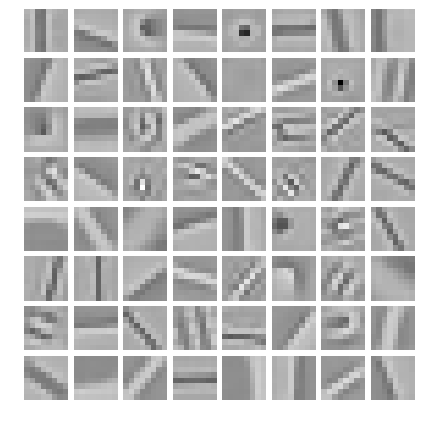

In [3]:
# Load dictionary
D = util.convdicts()['G:8x8x64']

# Display dictionary
fig = plot.figure(figsize=(7,7))
fgax = plot.imview(util.tiledict(D), fgrf=fig)

Set CBPDN solver class options.

In [4]:
# Set up ConvBPDNJoint options
lmbda = 1e-1
mu = 1e-2
opt = cbpdn.ConvBPDNJoint.Options({'Verbose' : True, 'MaxMainIter' : 200,
                              'LinSolveCheck' : True, 'RelStopTol' : 5e-3,
                              'AuxVarObj' : False})

Initialise and run CBPDN solver and then reconstruct image from sparse representation.

In [5]:
# Solve CBPDN problem
b = cbpdn.ConvBPDNJoint(D, sh, lmbda, mu, opt, dimK=0)
X = b.solve()

print("ConvBPDNJoint solve time: %.2fs" % b.timer.elapsed('solve'))

# Reconstruct representation
shr = b.reconstruct().squeeze()
imgr = sl + shr
print("Reconstruction PSNR: %.2fdB\n" % sm.psnr(img, imgr))

Itn   Fnc       DFid      Regℓ1     Regℓ2,1   r         s         ρ         
--------------------------------------------------------------------------
   0  5.27e+02  3.05e+00  4.94e+03  2.98e+03  9.94e-01  3.00e-02  6.00e+00
   1  4.49e+02  1.67e+01  4.08e+03  2.46e+03  9.07e-01  1.48e-01  6.00e+00
   2  3.68e+02  3.33e+01  3.16e+03  1.91e+03  4.81e-01  2.82e-01  1.05e+01
   3  3.46e+02  4.16e+01  2.87e+03  1.74e+03  2.73e-01  2.50e-01  1.05e+01
   4  3.47e+02  4.08e+01  2.89e+03  1.77e+03  2.32e-01  1.57e-01  7.77e+00
   5  3.14e+02  4.01e+01  2.58e+03  1.61e+03  2.05e-01  1.18e-01  6.67e+00
   6  2.81e+02  4.11e+01  2.26e+03  1.42e+03  1.71e-01  9.01e-02  6.67e+00
   7  2.57e+02  4.30e+01  2.01e+03  1.27e+03  1.40e-01  7.12e-02  6.67e+00
   8  2.42e+02  4.48e+01  1.86e+03  1.17e+03  1.12e-01  6.00e-02  6.67e+00
   9  2.35e+02  4.61e+01  1.78e+03  1.12e+03  9.08e-02  5.24e-02  6.67e+00
  10  2.29e+02  4.67e+01  1.71e+03  1.08e+03  7.57e-02  4.58e-02  6.67e+00
  11  2.23e+02  4.70e+0

Display low pass component and sum of absolute values of coefficient maps of highpass component.

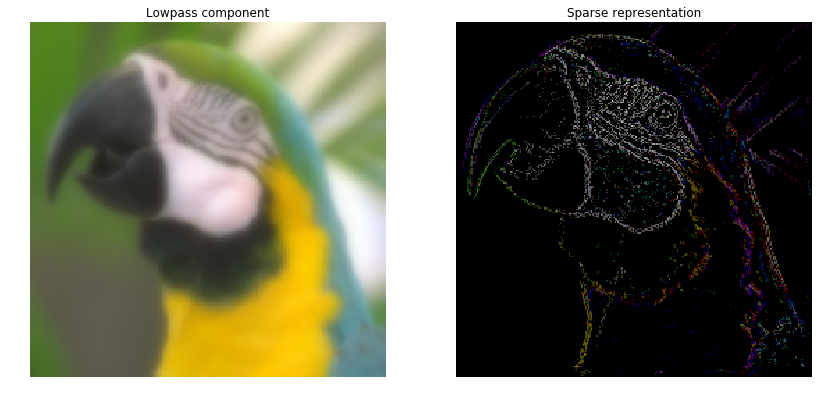

In [6]:
gamma = lambda x, g: x**g
fig = plot.figure(figsize=(14,7))
plot.subplot(1,2,1)
fgax = plot.imview(sl, title='Lowpass component', fgrf=fig)
plot.subplot(1,2,2)
fgax = plot.imview(gamma(np.sum(abs(X), axis=b.cri.axisM).squeeze(), 0.4),
            title='Sparse representation', fgrf=fig)

Display original and reconstructed images.

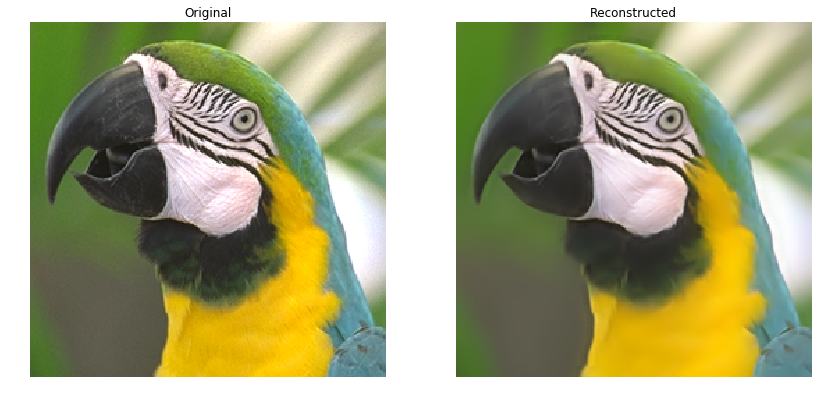

In [7]:
fig = plot.figure(figsize=(14,7))
plot.subplot(1,2,1)
fgax = plot.imview(img, title='Original', fgrf=fig)
plot.subplot(1,2,2)
fgax = plot.imview(imgr, title='Reconstructed', fgrf=fig)

Plot functional evolution during ADMM iterations.

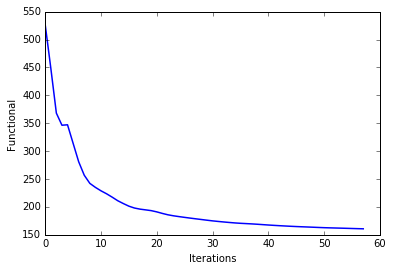

In [8]:
its = b.getitstat()
plot.plot(its.ObjFun, xlbl='Iterations', ylbl='Functional')
plot.close()

Plot evolution of ADMM residuals and ADMM penalty parameter.

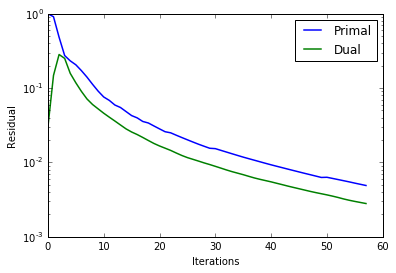

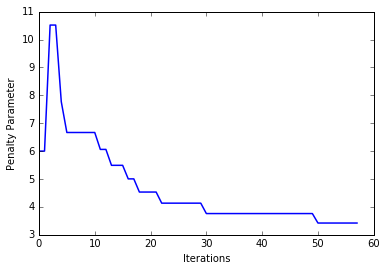

In [9]:
plot.plot(np.vstack((its.PrimalRsdl, its.DualRsdl)).T,
          ptyp='semilogy', xlbl='Iterations', ylbl='Residual',
          lgnd=['Primal', 'Dual'])
plot.plot(its.Rho, xlbl='Iterations', ylbl='Penalty Parameter')
plot.close()